In [1]:
# reload modules before executing code so we can modify modules and test without restarting kernel
%load_ext autoreload
%autoreload 2

import sys
import warnings
sys.path.append('..')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import run as run
from models import *
import utils

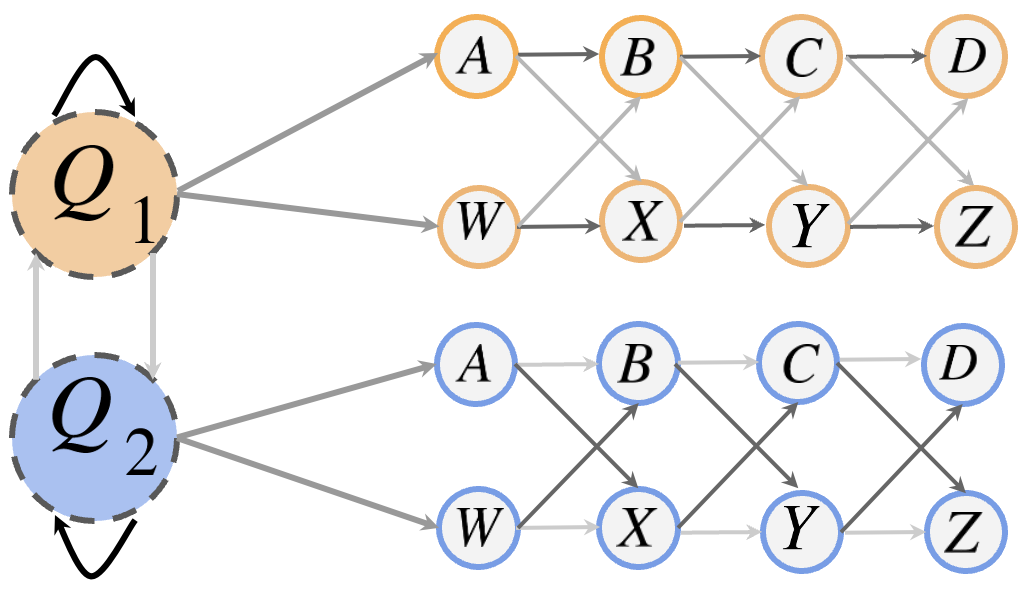

In [2]:
from PIL import Image

# visualize the pCSW environment.
img = Image.open('assets/pCSW.png')
img

#### 1. Explore the how manipulating the transition structure of the environment affects model performance.

Text(0.5, 0, 'Probability of transition')

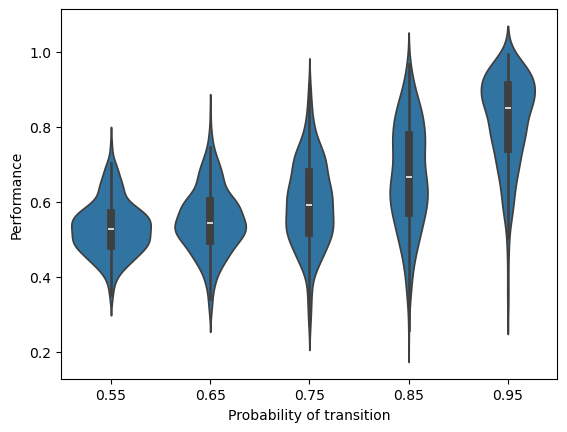

In [28]:
run_probs = [0.55, 0.65, 0.75, 0.85, 0.95]
all_sim_scores = []
dfs = []
for prob in run_probs:
    params = utils.Map(
        n_participants = 10,
        state_d = 11, # dimensionality of the state input
        context_d = 11, # dimensionality of the learned context representations
        output_d = 11, # dimensionality of the output layer
        episodic_lr = 1, # learning rate for the episodic pathway
        persistance = -0.8, # bias towards memory retention in the recurrent context module
        paradigms = ['blocked'],
        temperature = 0.1, # temperature for EM retrieval (lower is more argmax-like)
        n_optimization_steps = 10,
        probs = [prob, prob, prob],
        sim_thresh = 0.8
    )
    df, correct_probs, context_reps, sim_scores = run.run_experiment(params)
    all_sim_scores.append(sim_scores)
    dfs.append(df)

# plot the performance of the model as a function of the probability of context-appropriate transitions
df = pd.concat(dfs)
df['prob'] = np.repeat(run_probs, 2000)
sns.violinplot(df[df.trial>160], x='prob', y='probability')
plt.ylabel('Performance')
plt.xlabel('Probability of transition')

#### Can we induce "chunk" structure in encoding by manipulating the transition probabilities?

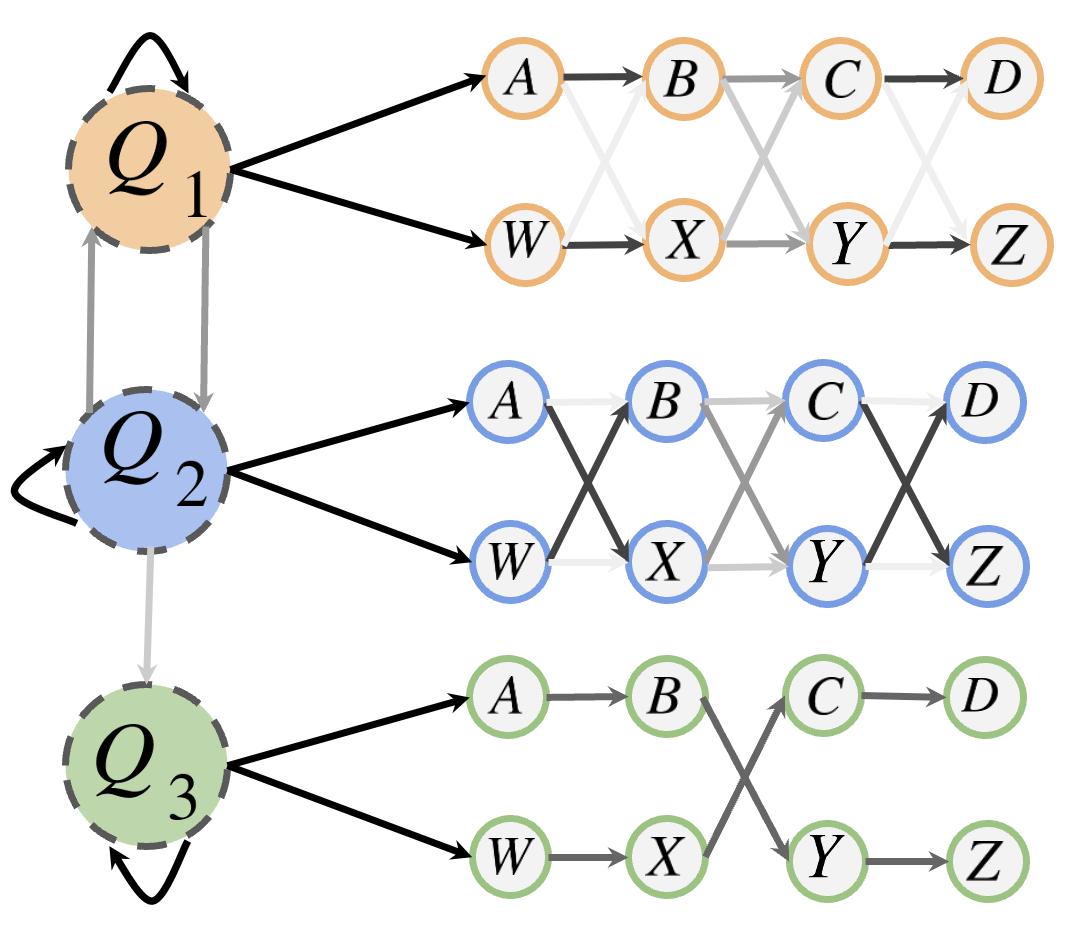

In [3]:
# visualize the chunked manipulation.
img = Image.open('assets/transition-chunking.png')
img

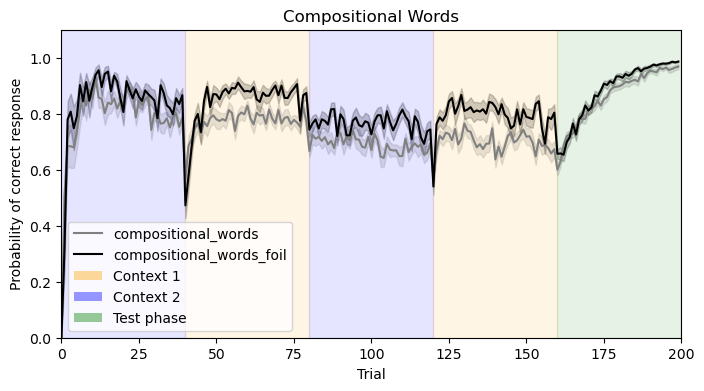

In [22]:
params = utils.Map(
    n_participants = 25,
    state_d = 11, # dimensionality of the state input
    context_d = 11, # dimensionality of the learned context representations
    output_d = 11, # dimensionality of the output layer
    episodic_lr = 1, # learning rate for the episodic pathway
    persistance = -0.8, # bias towards memory retention in the recurrent context module
    paradigms = ['compositional_words', 'compositional_words_foil'],
    temperature = 0.1, # temperature for EM retrieval (lower is more argmax-like)
    n_optimization_steps = 10,
    probs = [0.85, 0.6, 0.85],
    sim_thresh = 0.8
)
df, correct_probs, context_reps, sim_scores = run.run_experiment(params)
fig = utils.plot_results(df, 'Compositional Words')

t = 1.02, p = 0.31


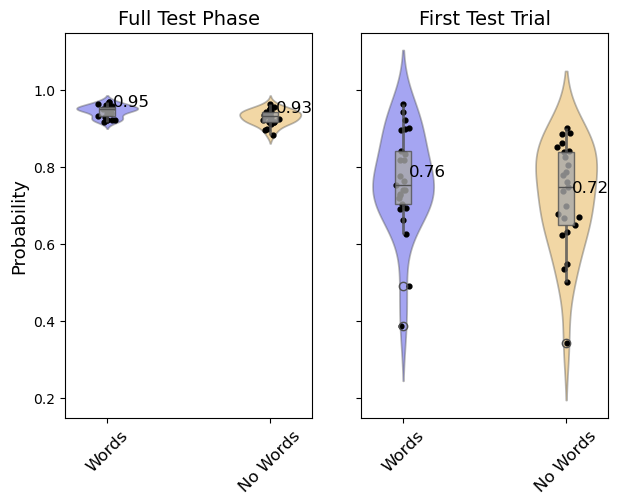

In [23]:
def plot_word_results(df, ax, title):
    conds = sorted(df.condition.unique())
    assert len(conds) == 2
    cmap = {key: val for (key, val) in zip(conds, ['blue', 'orange'])}
    sns.violinplot(data=df, x='condition', y='accuracy', alpha=0.4, palette=cmap, ax=ax, inner=None, gap=2.5, width=0.25)
    sns.boxplot(x='condition', y='accuracy', width=0.1, data=df, showcaps=False, boxprops={'facecolor':'darkgray', 'alpha':0.8}, whiskerprops={'linewidth':2, 'alpha':0.8}, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Probability', fontsize=13)
    ax.set_xlabel('')
    ax.set_xticklabels(['Words', 'No Words'], fontsize=12, rotation=45)
    # Add the probabilities as text and plot significance bars
    for i, condition in enumerate(conds):
        y = df[df.condition==condition].accuracy
        x = np.random.normal(i, 0.025, size=len(y))
        ax.scatter(x, y, c='black', s=12)
        mean = np.mean(y)
        ax.text(i+0.15, mean+0.025, f'{mean:.2f}', ha='center', va='center', color='black', fontsize=12)


state_ind = 4 # 1-5: index of the state to examine.
reps = context_reps.reshape(-1, 5, 11)
probs = correct_probs.squeeze().reshape(-1, 5, 11)

# First, plot overall performance during the entire test phase.
test_trials = probs[df.trial>=160].reshape(params.n_participants*2, -1, 5, 11)
comp_words = test_trials[::2, :, state_ind]
comp_words_foil = test_trials[1::2, :, state_ind]
full_acc_comp_words = comp_words.max(axis=2).mean(axis=-1)
full_acc_foil = comp_words_foil.max(axis=2).mean(axis=-1)

# Second, plot the performance of the transition of interest for the first test trial.
first_test_trial = probs[df.trial==160]
comp_words = first_test_trial[::2, state_ind] # 3 is the index of the first second word state trial
comp_words_foil = first_test_trial[1::2, state_ind]
acc_comp_words = comp_words.max(axis=1)
acc_foil = comp_words_foil.max(axis=1)
res_df = pd.DataFrame({'comp_words': acc_comp_words, 'comp_words_foil': acc_foil, 'full_comp_words': full_acc_comp_words, 'full_comp_words_foil': full_acc_foil})
res_df = res_df.stack().reset_index()
res_df.columns = ['participant', 'condition', 'accuracy']

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(7, 5), sharey=True)

# First plot overall performance
plot_df = res_df[res_df.condition.isin(['full_comp_words', 'full_comp_words_foil'])]
plot_word_results(plot_df, axes[0], 'Full Test Phase')

# Second plot the performance of the transition of interest for the first test trial.
plot_df = res_df[res_df.condition.isin(['comp_words', 'comp_words_foil'])]
plot_word_results(plot_df, axes[1], 'First Test Trial')

# Compute a t-test
t, p = ttest_ind(acc_comp_words, acc_foil)  
print(f't = {t:.2f}, p = {p:.2f}')

### Things to explore
#### 1. How does the stochastisticity of the environment affect interleaved learning?
#### 2. Do models trained with an interleaved curriculum generalize better to context 3 when trained with a blocked environment?
#### 3. How do the context representations of context 3 compare to those observed in Q1 and Q2?
#### 4. How does the integration rate influence robustness to non-deterministic transitions?